# Mapping ALE SNPs onto Bitome Data

## Setup

### Import Required Packages

In [1]:
# built-in modules
from collections import Counter
import os
from pathlib import Path
import re
import sys

# third-party modules
from Bio.Alphabet import IUPAC
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu

BITOME_KB_PATH = Path('..', 'bitome-kb')
sys.path.append(BITOME_KB_PATH.absolute().as_posix())
from bitome.core import Bitome

### Set Global Variables

In [2]:
FIG_PATH = Path('..', 'figures', 'figure_4')
LOCAL_CACHE_PATH = Path('..', 'local_cache')
DATA_PATH = Path('..', 'data')

plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']

### Load Bitome KB

In [4]:
test_bitome = Bitome.init_from_file(Path(LOCAL_CACHE_PATH, 'bitome.pkl'))
column_sums = np.asarray(test_bitome.matrix.sum(axis=0)).flatten()

## Processing Mutation Data

In [7]:
# --- SNP frequency by nt information frequency ---
ale_data_path = Path(DATA_PATH, 'aledb_muts_public')
snp_df = pd.DataFrame(columns=['Position', 'Details'])
for mutation_data_file in os.listdir(ale_data_path):
    mutation_df = pd.read_csv(
        Path(ale_data_path, mutation_data_file),
        index_col=None,
        usecols=[0, 1, 2, 3, 10],
        names=['Mut ID', 'Reference Seq', 'Position', 'Mutation Type', 'Details']
    )
    # verified that there are no variants of the NC_000913 ref seq tag in any of the files
    mutation_df_ecoli = mutation_df[mutation_df['Reference Seq'] == 'NC_000913']
    mutation_df_snps = mutation_df_ecoli[mutation_df_ecoli['Mutation Type'] == 'SNP'][[
        'Position',
        'Details'
    ]]
    snp_df = pd.concat([snp_df, mutation_df_snps])


def snp_type_from_details(snp_row) -> str:
    """
    Parses the details string from an ALEdb file to determine if a SNP is intergenic, synonymous or non-synonymous

    :param snp_row: the raw details string to parse
    :return str type_of_snp: the resulting SNP type
    """
    details = snp_row.Details
    if 'intergenic' in details or 'pseudogene' in details or 'noncoding' in details:
        type_of_snp = 'intergenic'
    else:
        # assume just one
        snp_aa_code = list(re.findall(r'[A-Z*][0-9]{1,5}[A-Z*]', details))[0]
        if snp_aa_code[0] == snp_aa_code[-1]:
            type_of_snp = 'synonymous'
        elif snp_aa_code[-1] == '*':
            type_of_snp = 'nonsense'
        else:
            type_of_snp = 'missense'
    return type_of_snp


def snp_aa_from_details(snp_row, mutated=False) -> str:
    """
    Parses the details string from an ALEdb file to determine the amino acid that a SNP targeted

    :param snp_row: the raw details string to parse
    :param bool mutated: indicates if the amino acid that was mutated TO should be returned
    :return str snp_aa: the AA the SNP targeted
    """
    details = snp_row.Details
    if 'intergenic' in details or 'pseudogene' in details or 'noncoding' in details:
        snp_aa = None
    else:
        # assume just one
        snp_aa_code = list(re.findall(r'[A-Z*][0-9]{1,5}[A-Z*]', details))[0]
        if mutated:
            snp_aa = snp_aa_code[-1]
        else:
            snp_aa = snp_aa_code[0]
        if snp_aa == '*':
            snp_aa = None
    return snp_aa


# cleaning up the dataframe to make sure we have integer positions, some extra mutation information
snp_df['Position'] = snp_df.apply(lambda row: int(row.Position.replace(',', '')), axis=1)
snp_df['Type'] = snp_df.apply(snp_type_from_details, axis=1)
snp_df['From'] = snp_df.apply(snp_aa_from_details, axis=1)
snp_df['To'] = snp_df.apply(lambda row: snp_aa_from_details(row, mutated=True), axis=1)

# import this separate file that has all K12 mutants; this one has midpoints and tech replicates removed, though
# so we can use it to filter down the public; this is a little hacky instead of using Patrick's pipeline to
# actually just get this filtering done on public ALEdb
filtered_mut_df_private = pd.read_pickle(Path(DATA_PATH, 'filtered_K12_mut_df.pkl'))
snp_df_private = filtered_mut_df_private[filtered_mut_df_private['Mutation Type'] == 'SNP']
filtered_coding_snp_df_private = snp_df_private[snp_df_private['coding'] == 1]

# only take the positions in our snp_df that also show up in the filtered db
snp_df = snp_df[snp_df['Position'].isin(filtered_coding_snp_df_private['Position'].astype(int))]

all_snp_locations = list(snp_df['Position'])
location_counts = Counter(all_snp_locations)

## Figures

### Bit Density in Mutated Positions

U: 13825471181; P: 1.63E-02


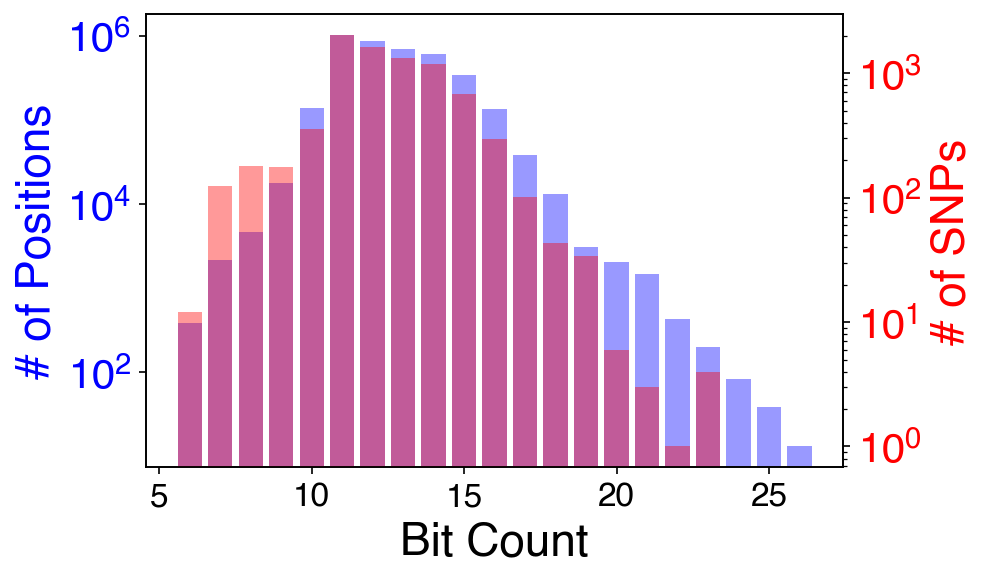

In [8]:
# get the column sums JUST in coding regions
coding_gene_mask = np.where(
    np.asarray(test_bitome.extract(row_labels=['gene_CDS'], base_name=True).sum(axis=0)).flatten() > 0
)[0]
column_sums_coding = column_sums[coding_gene_mask]

non_coding_locs = set(location_counts.keys()).difference(set(coding_gene_mask+1))
location_counts = {k: v for k, v in location_counts.items() if k not in non_coding_locs}

# the SNP locations are 1-indexed
snp_counts_by_column = [location_counts.get(i+1, 0) for i in range(len(column_sums))]
bit_snp_tuples_nonzero = [tup for tup in zip(column_sums, snp_counts_by_column) if tup[1] > 0]

column_sums_w_snp, snp_counts_nonzero = list(zip(*bit_snp_tuples_nonzero))

unique_col_sums = list(set(column_sums_w_snp))
snps_by_col_sum = []
for unique_col_sum in unique_col_sums:
    snp_tups_for_col_sum = [tup for tup in bit_snp_tuples_nonzero if tup[0] == unique_col_sum]
    total_snps = sum([tup[1] for tup in snp_tups_for_col_sum])
    snps_by_col_sum.append(total_snps)

col_sum_counts = Counter(column_sums_coding)

u_stat, p_value = mannwhitneyu(column_sums_coding, column_sums_w_snp, alternative='two-sided')
print(f'U: {u_stat:.0f}; P: {p_value:.2E}')

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.bar(col_sum_counts.keys(), col_sum_counts.values(), log=True, color=(0, 0, 1, 0.4))
ax.set_xlabel('Bit Count', fontsize=22)
ax.set_ylabel('# of Positions', color=(0, 0, 1), fontsize=22)
ax.tick_params(axis='x', labelsize='16')
ax.tick_params(axis='y', labelcolor=(0, 0, 1), labelsize=20)
ax2.bar(unique_col_sums, snps_by_col_sum, log=True, color=(1, 0, 0, 0.4))
ax2.set_ylabel('# of SNPs', color=(1, 0, 0), fontsize=22)
ax2.tick_params(axis='y', labelcolor=(1, 0, 0), labelsize=20)
plt.savefig(Path(FIG_PATH, 'bits_mutations.png'), bbox_inches='tight')
plt.show()

### Mutations per Amino Acid

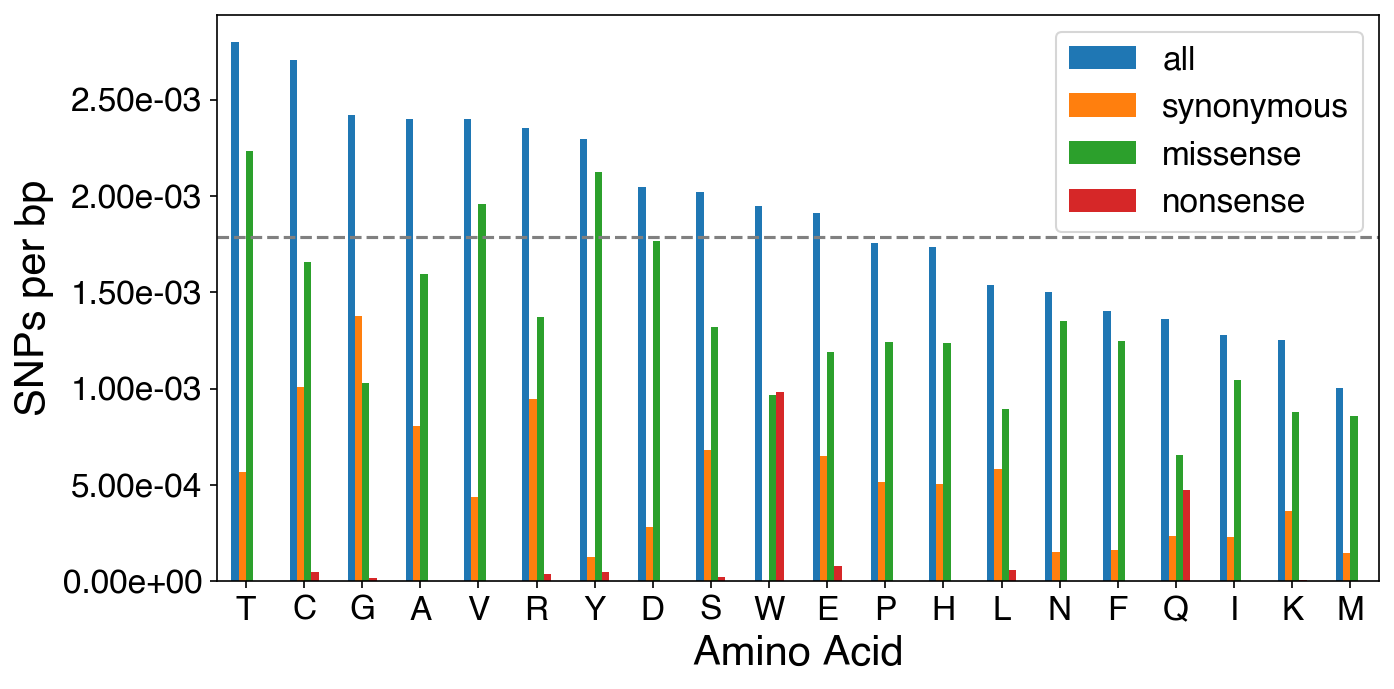

In [9]:
# --- mutations by amino acid ---
overall_rate = len(all_snp_locations)/test_bitome.matrix.shape[1]
multi_snp_locs = {k: v for k, v in location_counts.items() if v > 1}

amino_acids = IUPAC.protein.letters
snps_by_aa = {}
for aa in amino_acids:
    aa_vector = np.asarray(test_bitome.extract(row_labels=[f'amino_acid_{aa}'], base_name=True).sum(axis=0)).flatten()
    aa_loc_total = len(np.where(aa_vector > 0)[0])
    aa_snp_df = snp_df[snp_df['From'] == aa]
    aa_snp_frequency_dict = {
        'all': aa_snp_df.shape[0]/aa_loc_total,
        'synonymous': aa_snp_df[aa_snp_df['Type'] == 'synonymous'].shape[0]/aa_loc_total,
        'missense': aa_snp_df[aa_snp_df['Type'] == 'missense'].shape[0]/aa_loc_total,
        'nonsense': aa_snp_df[aa_snp_df['Type'] == 'nonsense'].shape[0]/aa_loc_total
    }
    snps_by_aa[aa] = aa_snp_frequency_dict

color_lookup = {'nonpolar': 'tab:gray', 'polar': 'tab:blue', 'charged': 'tab:red'}
amino_acid_category_lookup = {
    'Y': 'polar',
    'M': 'nonpolar',
    'H': 'charged',
    'W': 'nonpolar',
    'C': 'polar',
    'L': 'nonpolar',
    'A': 'nonpolar',
    'G': 'nonpolar',
    'V': 'nonpolar',
    'I': 'nonpolar',
    'E': 'charged',
    'S': 'polar',
    'R': 'charged',
    'T': 'polar',
    'D': 'charged',
    'P': 'nonpolar',
    'Q': 'polar',
    'K': 'charged',
    'F': 'nonpolar',
    'N': 'polar'
}

# alternate mutations view
snp_by_aa_df = pd.DataFrame(
    data={
        'all': [aa_dict['all'] for aa_dict in snps_by_aa.values()],
        'synonymous': [aa_dict['synonymous'] for aa_dict in snps_by_aa.values()],
        'missense': [aa_dict['missense'] for aa_dict in snps_by_aa.values()],
        'nonsense': [aa_dict['nonsense'] for aa_dict in snps_by_aa.values()]
    },
    index=list(snps_by_aa.keys())
).sort_values(by='all', ascending=False)
ax = snp_by_aa_df.plot.bar(figsize=(10, 5), rot=0)
ax.axhline(overall_rate, linestyle='--', color='gray')
ax.tick_params(axis='both', labelsize=16)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
ax.set_xlabel('Amino Acid', fontsize=20)
ax.set_ylabel('SNPs per bp', fontsize=20)
ax.legend(prop={'size': 16})
plt.savefig(Path(FIG_PATH, 'muts_by_snp_alt.svg'))
plt.show()